In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix
from tqdm.notebook import tqdm

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level, various_metrics
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints')

models_to_compare = {}
for file in os.listdir(checkpoint_dir):
    if file.startswith('binary_cl2'):
        if file.endswith('binary_cl2'):
            nickname = 'current'
        else:
            nickname = re.search('(binary_cl2)_(.*)', file).group(2)
        nickname = 'model_' + nickname
        try:
            res = pd.read_csv(os.path.join(checkpoint_dir, file, 'val_results500.csv'))
            res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
            models_to_compare[nickname] = {'original_name': file, 'df': res}
        except:
            pass

In [5]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_val_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_val_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [6]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

In [7]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'val500.csv'))

In [8]:
assert test500.couples.isin(gene_pairs_test).all()

# PLOTS

## Metrics

In [9]:
N_iters = 25

In [10]:
def balance_df(df):
    negs = df[df.ground_truth == 0]
    poss = df[df.ground_truth == 1]
    
    n_to_sample = min(poss.shape[0], negs.shape[0])

    if poss.shape[0] > negs.shape[0]:
        return pd.concat([poss.sample(n_to_sample), negs], axis = 0).reset_index(drop = True)
    else:
        return pd.concat([negs.sample(n_to_sample), poss], axis = 0).reset_index(drop = True)

In [11]:
results = {}
set_collected = []

In [12]:
key_name = 'full_data'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
key_name = 'easypos_easyneg_hardneg'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
key_name = 'easypos_easyneg_hardneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
key_name = 'easypos_smartneg'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
key_name = 'easypos_smartneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
key_name = 'easypos_smartneg_not_in_train_55_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.55)|(res.probability<(1-0.55))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
key_name = 'easypos_smartneg_not_in_train_65_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.65)|(res.probability<(1-0.65))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
metric_to_print = 'acc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 acc: 0.575
model_2 acc: 0.57
model_4 acc: 0.553
model_5 acc: 0.553
model_old acc: 0.575
model_6 acc: 0.555
model_3 acc: 0.562


---  easypos_easyneg_hardneg  --- 
model_1 acc: 0.671
model_2 acc: 0.661
model_4 acc: 0.635
model_5 acc: 0.639
model_old acc: 0.648
model_6 acc: 0.639
model_3 acc: 0.64


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 acc: 0.627
model_2 acc: 0.675
model_4 acc: 0.575
model_5 acc: 0.607
model_old acc: 0.627
model_6 acc: 0.627
model_3 acc: 0.59


---  easypos_smartneg  --- 
model_1 acc: 0.567
model_2 acc: 0.563
model_4 acc: 0.547
model_5 acc: 0.546
model_old acc: 0.571
model_6 acc: 0.549
model_3 acc: 0.557


---  easypos_smartneg_not_in_train  --- 
model_1 acc: 0.53
model_2 acc: 0.515
model_4 acc: 0.506
model_5 acc: 0.496
model_old acc: 0.527
model_6 acc: 0.51
model_3 acc: 0.517


---  easypos_smartneg_not_in_train_55_conf  --- 
model_1 acc: 0.539
model_2 acc: 0.531
model_4 acc: 0.526
model_5 acc: 0.519
model_old acc: 0.53
mo

In [20]:
metric_to_print = 'roc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 roc: 0.61
model_2 roc: 0.603
model_4 roc: 0.581
model_5 roc: 0.578
model_old roc: 0.612
model_6 roc: 0.584
model_3 roc: 0.593


---  easypos_easyneg_hardneg  --- 
model_1 roc: 0.744
model_2 roc: 0.754
model_4 roc: 0.722
model_5 roc: 0.727
model_old roc: 0.707
model_6 roc: 0.725
model_3 roc: 0.702


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 roc: 0.678
model_2 roc: 0.773
model_4 roc: 0.781
model_5 roc: 0.845
model_old roc: 0.704
model_6 roc: 0.839
model_3 roc: 0.706


---  easypos_smartneg  --- 
model_1 roc: 0.6
model_2 roc: 0.592
model_4 roc: 0.57
model_5 roc: 0.566
model_old roc: 0.606
model_6 roc: 0.574
model_3 roc: 0.586


---  easypos_smartneg_not_in_train  --- 
model_1 roc: 0.56
model_2 roc: 0.55
model_4 roc: 0.52
model_5 roc: 0.51
model_old roc: 0.556
model_6 roc: 0.516
model_3 roc: 0.511


---  easypos_smartneg_not_in_train_55_conf  --- 
model_1 roc: 0.573
model_2 roc: 0.572
model_4 roc: 0.561
model_5 roc: 0.553
model_old roc: 0.596
mode

In [21]:
metric_to_print = 'perc_data'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 perc_data: 100.0
model_2 perc_data: 100.0
model_4 perc_data: 100.0
model_5 perc_data: 100.0
model_old perc_data: 100.0
model_6 perc_data: 100.0
model_3 perc_data: 100.0


---  easypos_easyneg_hardneg  --- 
model_1 perc_data: 36.65
model_2 perc_data: 36.65
model_4 perc_data: 36.65
model_5 perc_data: 36.65
model_old perc_data: 36.65
model_6 perc_data: 36.65
model_3 perc_data: 36.65


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 perc_data: 0.35
model_2 perc_data: 0.35
model_4 perc_data: 0.35
model_5 perc_data: 0.35
model_old perc_data: 0.35
model_6 perc_data: 0.35
model_3 perc_data: 0.35


---  easypos_smartneg  --- 
model_1 perc_data: 95.34
model_2 perc_data: 95.34
model_4 perc_data: 95.34
model_5 perc_data: 95.34
model_old perc_data: 95.34
model_6 perc_data: 95.34
model_3 perc_data: 95.34


---  easypos_smartneg_not_in_train  --- 
model_1 perc_data: 1.0
model_2 perc_data: 1.0
model_4 perc_data: 1.0
model_5 perc_data: 1.0
model_old perc_data: 1.0
m

In [22]:
best_model_chosen = 'model_1'


# Define the path to the file containing the args namespace
args_path = os.path.join(ROOT_DIR, 'checkpoints', models_to_compare[best_model_chosen]['original_name'], 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)
print(args_dict['policies_train'][0].height_bins)
print(args_dict['policies_train'][0].height_probabilities)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 256, 'n_channels1_cnn': 256, 'n_channels2_cnn': 512, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7fc5eb8d2680>, <dataset.data.SmartNegAugment object at 0x7fc5eb8d3b80>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7fc5eb8d2200>, <dataset.data.SmartNegAugment object at 0x7fc5eb8d24a0>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star

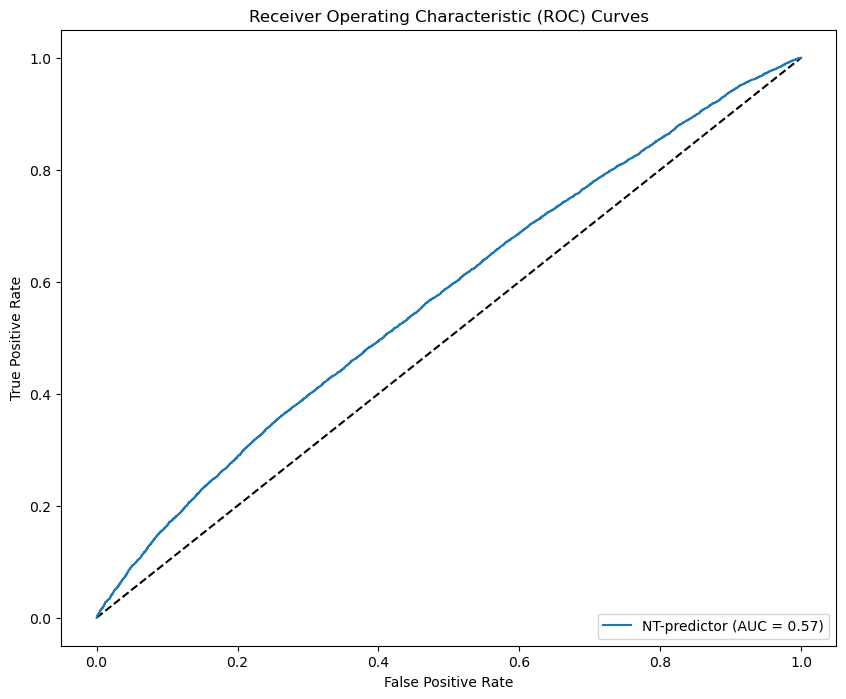

In [24]:
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

0.8423373759647188


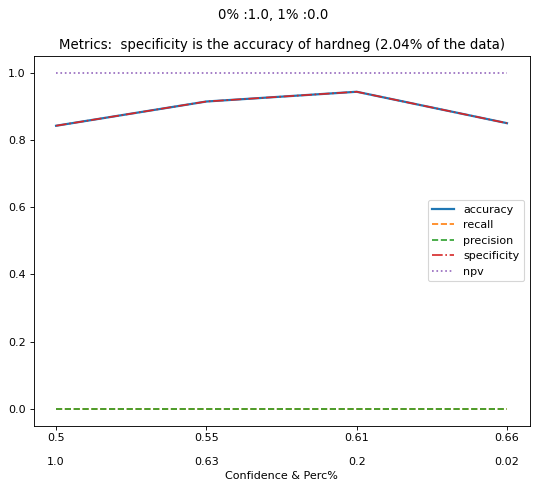

In [25]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.8727429062768701


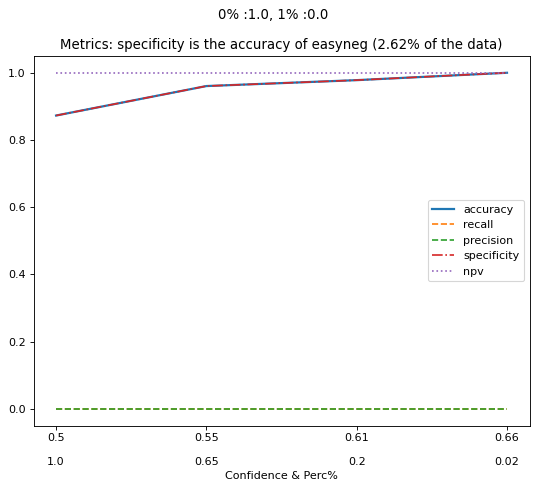

In [26]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

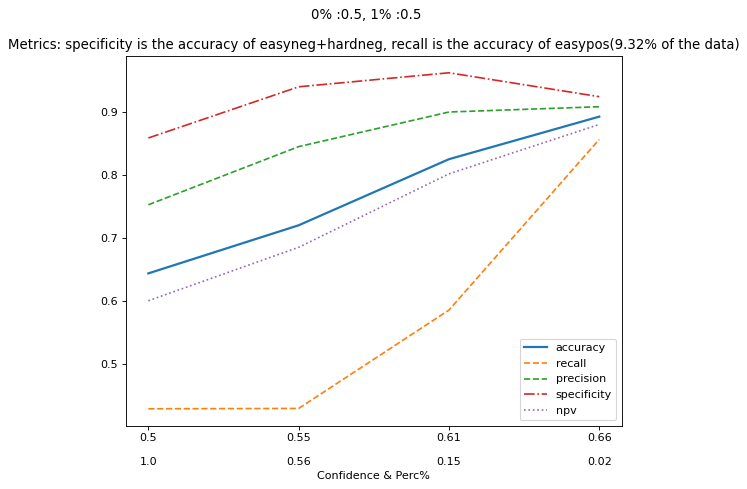

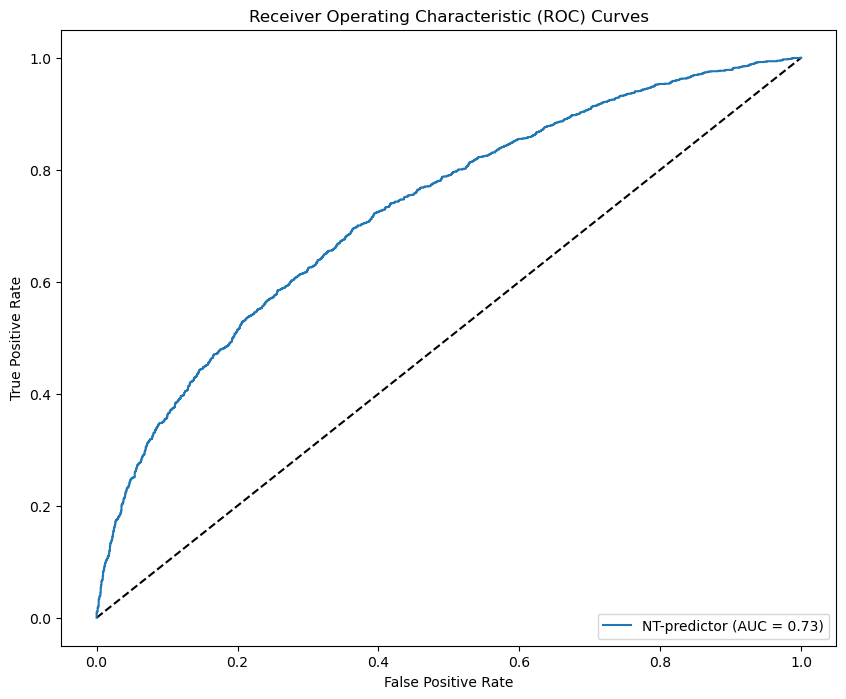

In [27]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

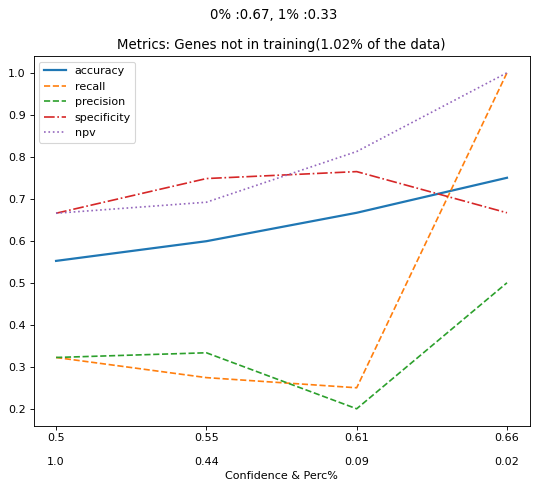

In [28]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

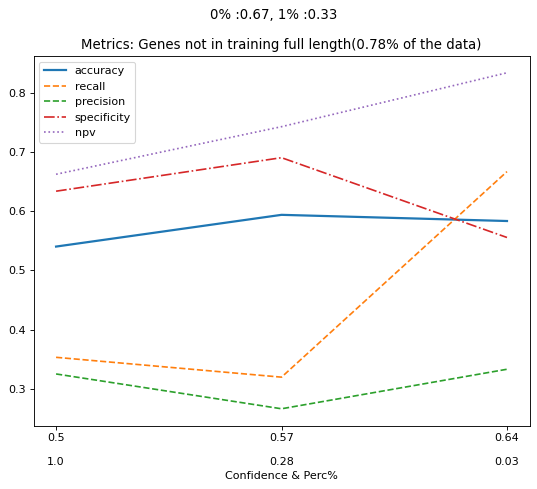

In [29]:
not_in_train_fl = not_in_train[(not_in_train.original_length1 <= MAX_RNA_SIZE)&(not_in_train.original_length2 <= MAX_RNA_SIZE)]
not_in_train_fl = not_in_train_fl[(not_in_train_fl.policy == 'easypos')|(not_in_train_fl.policy == 'smartneg')]
obtain_plot(not_in_train_fl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training full length', n_conf = 8)

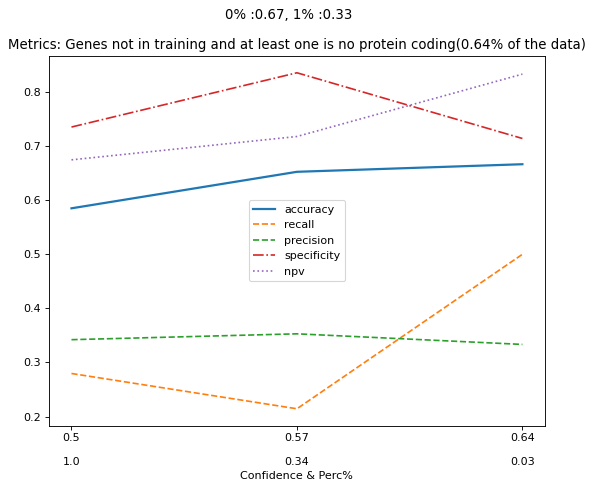

In [30]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

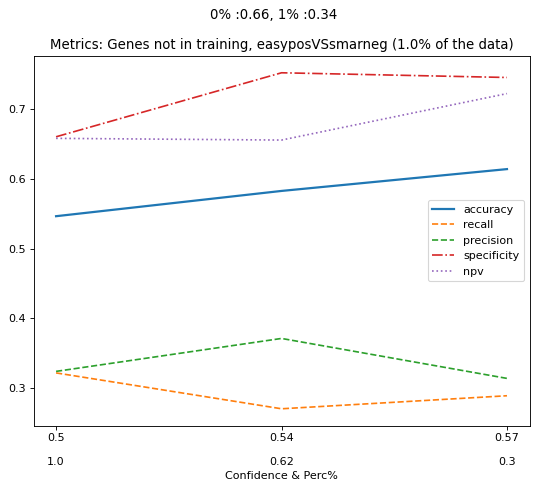

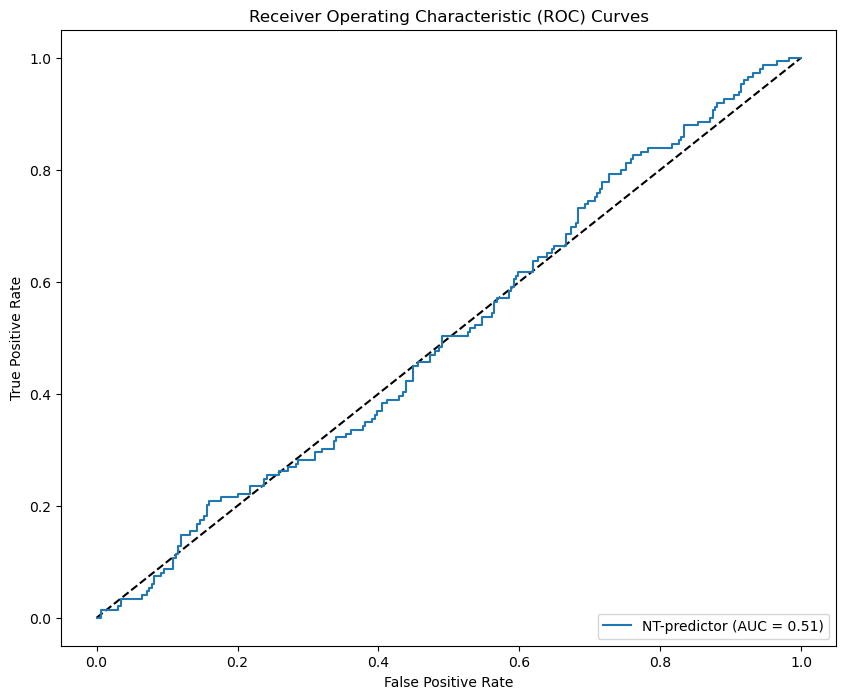

In [32]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
obtain_plot(not_in_train_epsn, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn.ground_truth)

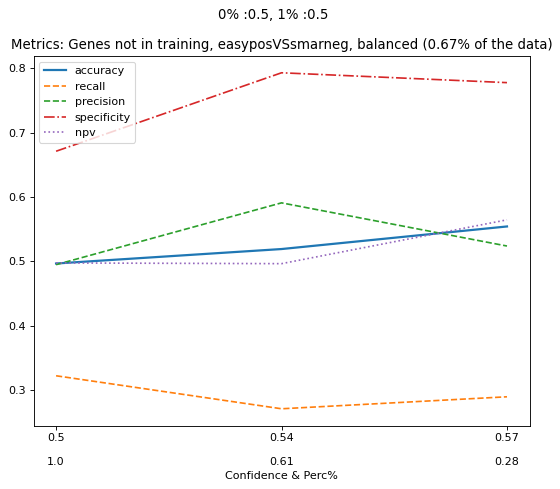

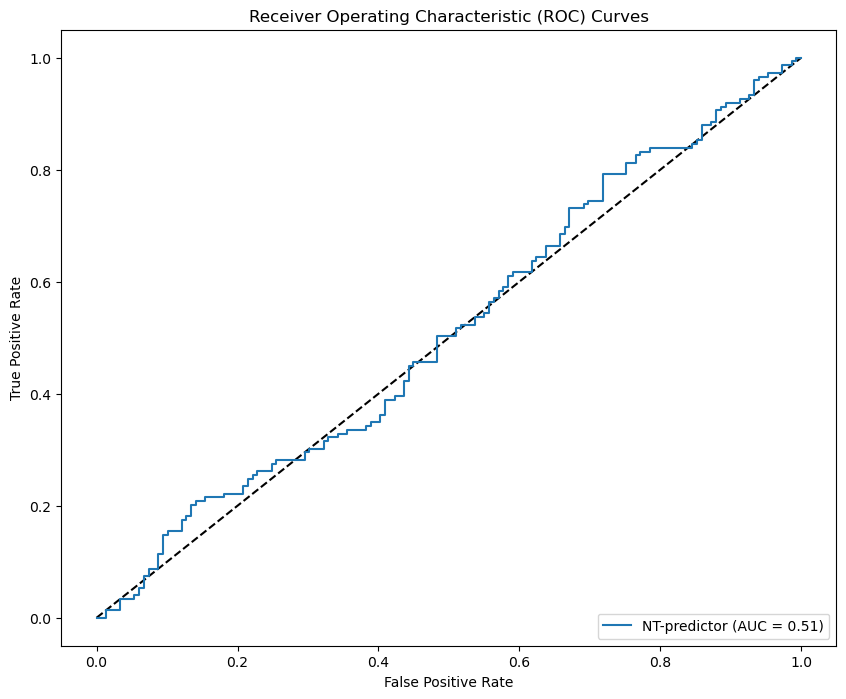

In [33]:
negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

not_in_train_epsn_balanced = pd.concat([negs.sample(len(poss)), poss], axis = 0)
obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg, balanced ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn_balanced.ground_truth)

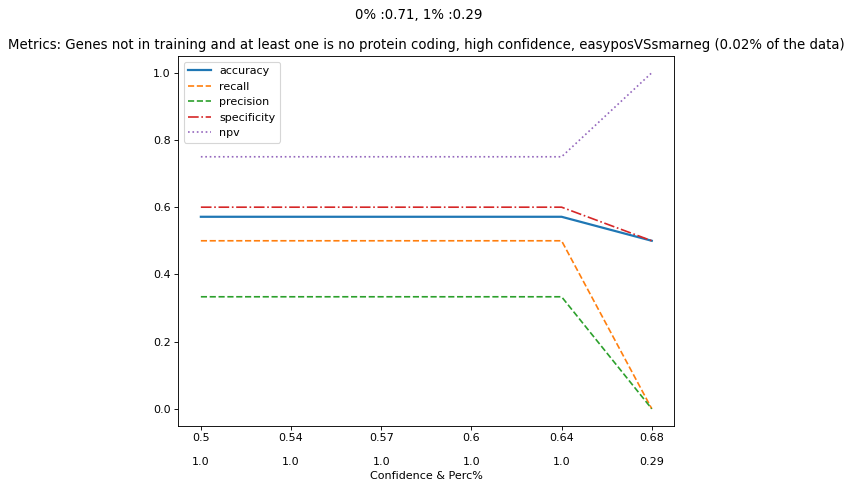

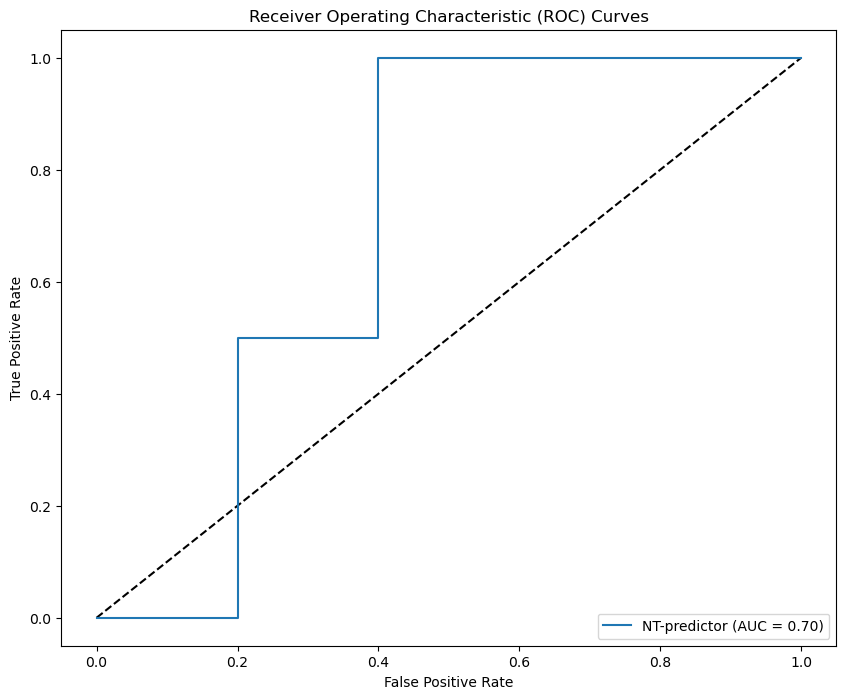

In [34]:
confidence_level = 0.65

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT-predictor'}], no_pc_no_train.ground_truth)

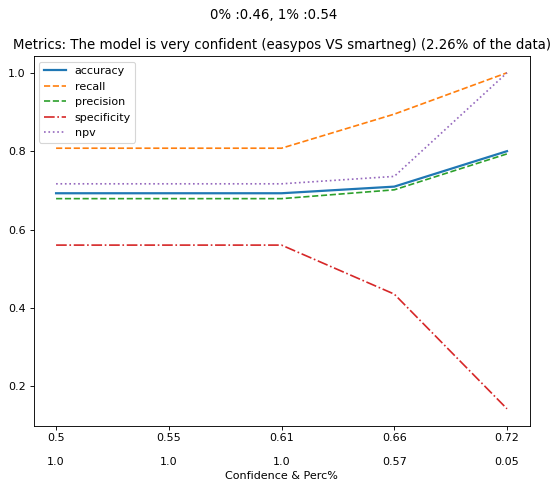

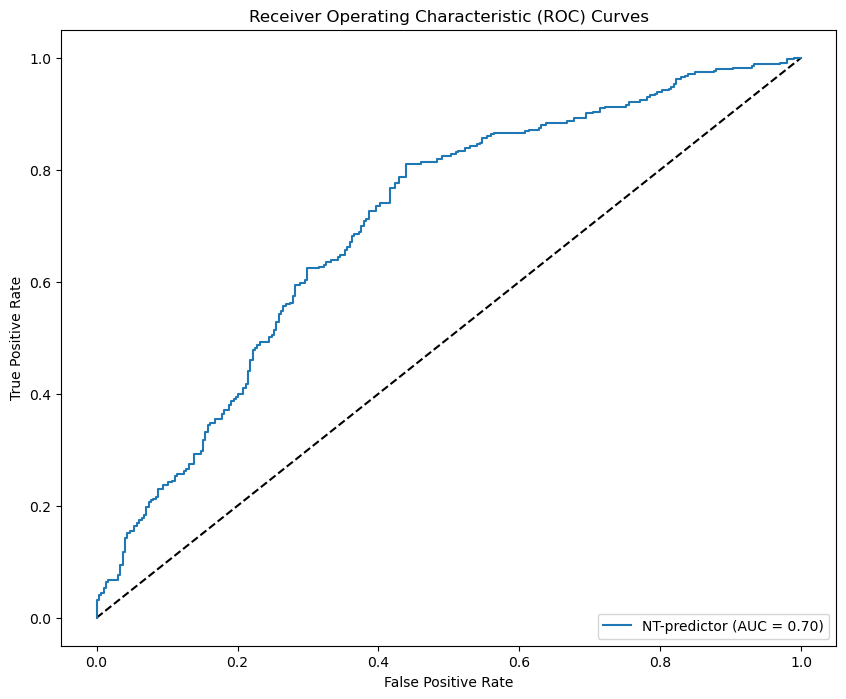

In [35]:
confidence_level = 0.65
high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

obtain_plot(high_prob_pairs, n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

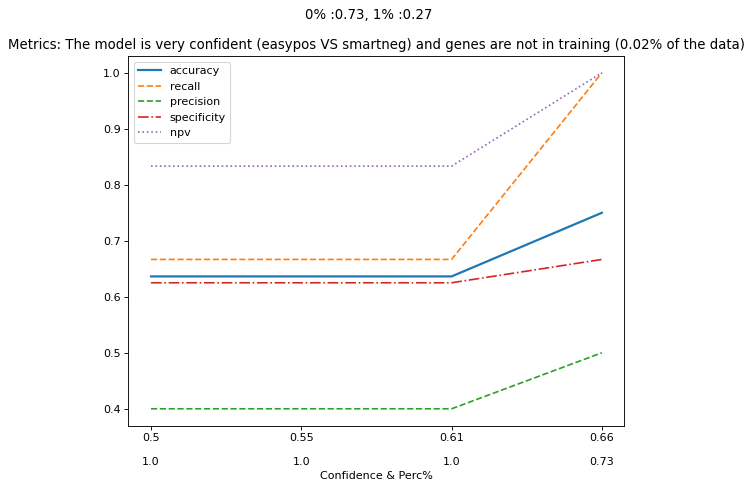

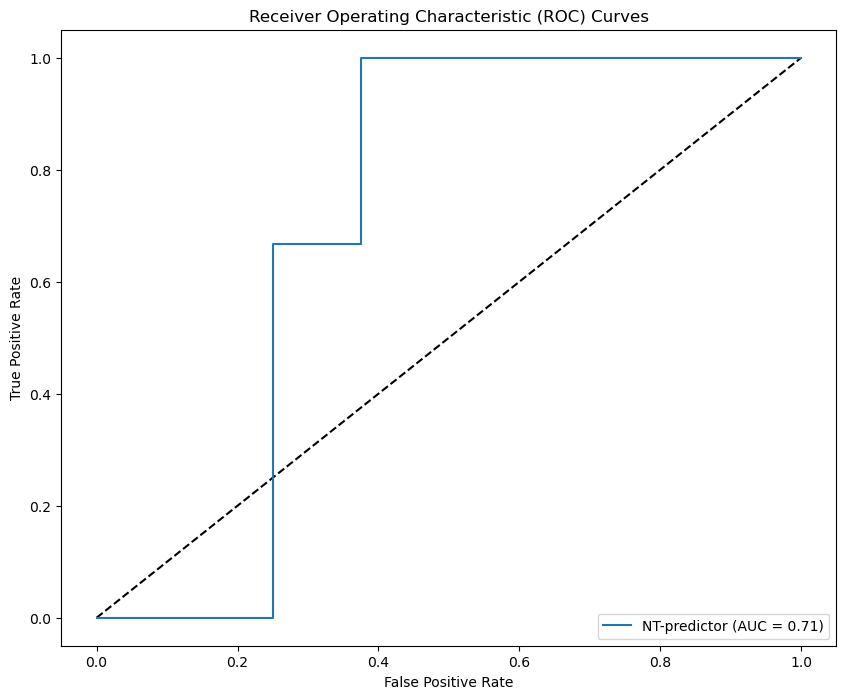

In [36]:
confidence_level = 0.65
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

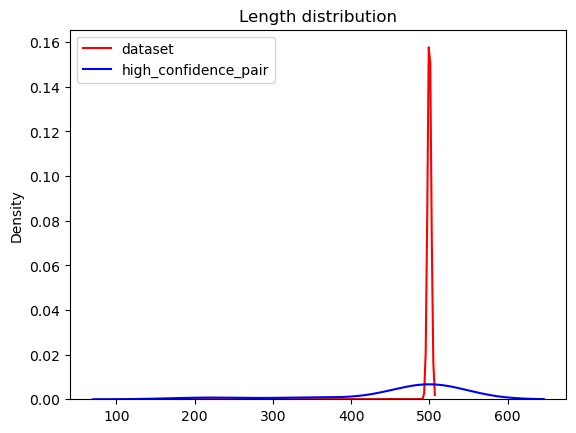

In [37]:
sns.kdeplot(list(pd.concat([easypos_smartneg.len_g1, easypos_smartneg.len_g2], axis = 0)), color = 'red', label = 'dataset')
sns.kdeplot(list(pd.concat([high_prob_pairs.len_g1, high_prob_pairs.len_g2], axis = 0)), color = 'blue', label = 'high_confidence_pair')
plt.title(f'Length distribution')
plt.legend()

In [38]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [39]:
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [40]:
intarna.shape[0]

44397

In [41]:
res.shape[0]

44397

In [42]:
auc_nt = []
auc_intarna = []

for i in range(500):
    # undersample 0 class
    res0 = res[res.ground_truth == 0]
    res1 = res[res.ground_truth == 1]
    balanced = pd.concat([res0.sample(res1.shape[0]), res1], axis = 0)

    fpr, tpr, _ = roc_curve(balanced.ground_truth, balanced.probability)
    roc_auc = auc(fpr, tpr)
    auc_nt.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(abs(1 - balanced.ground_truth), balanced.E_norm)
    roc_auc = auc(fpr, tpr)
    auc_intarna.append(roc_auc)

In [43]:
print(np.mean(auc_nt), 
      np.mean(auc_intarna)
     )

0.5777258848938702 0.5341373793394166


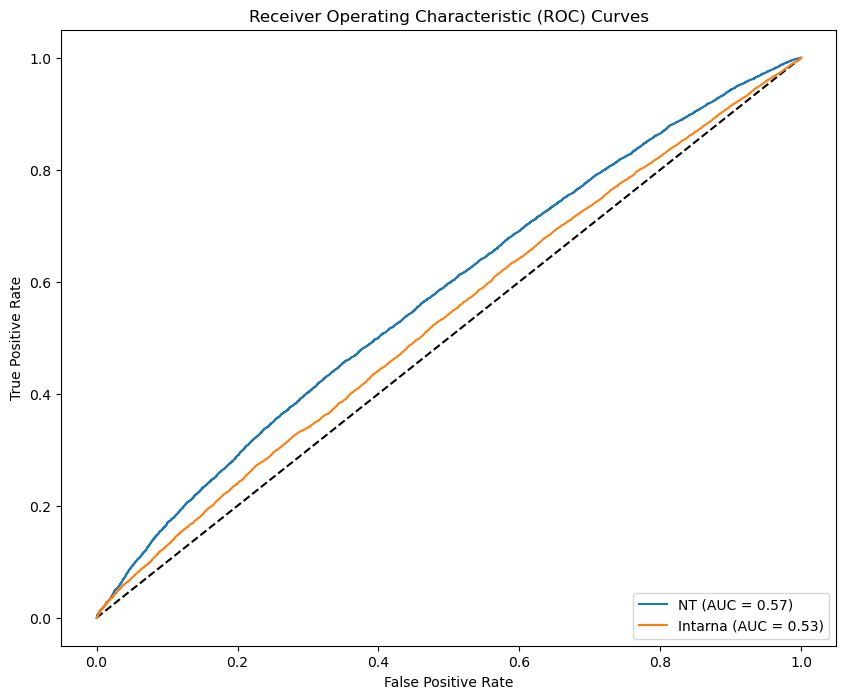

In [44]:
plot_roc_curves([{'prob': balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced.E_norm), 'model_name': 'Intarna'}
                ], balanced.ground_truth)

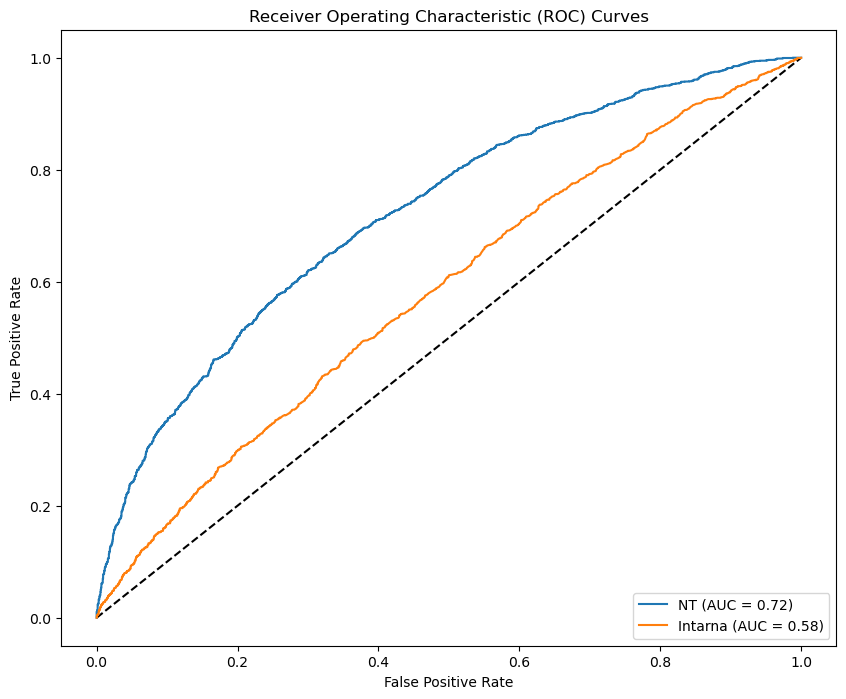

In [45]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

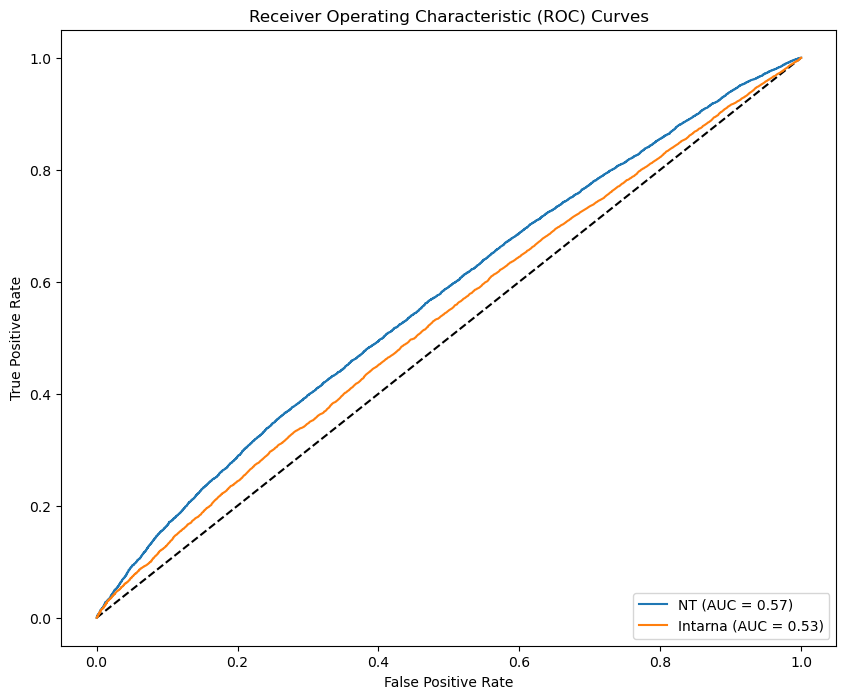

In [46]:
test = pd.read_csv(os.path.join(metadata_dir, f'val_sampled.csv'))
test = test[['id_gene1_sample', 'id_gene2_sample']]

res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

#### Compare AUC based on confidence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


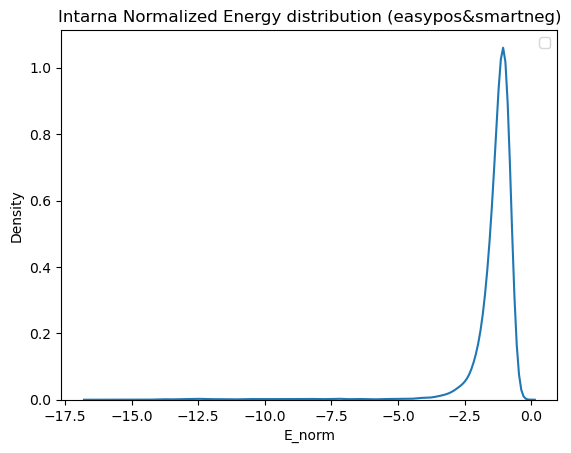

In [47]:
sns.kdeplot(easypos_smartneg.E_norm)
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

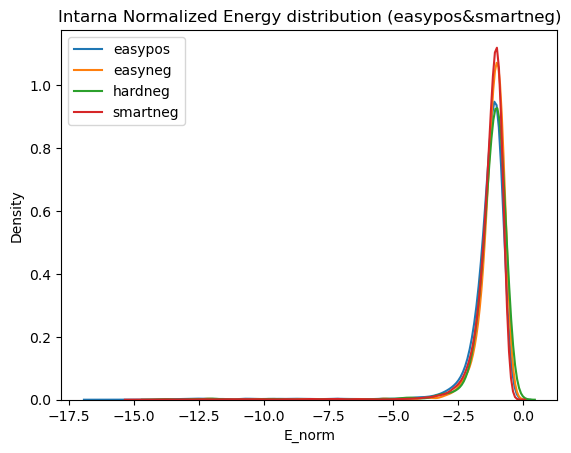

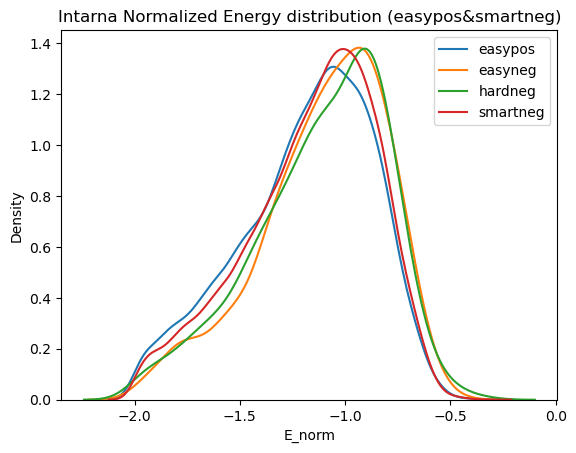

In [48]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [49]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  2.0 %


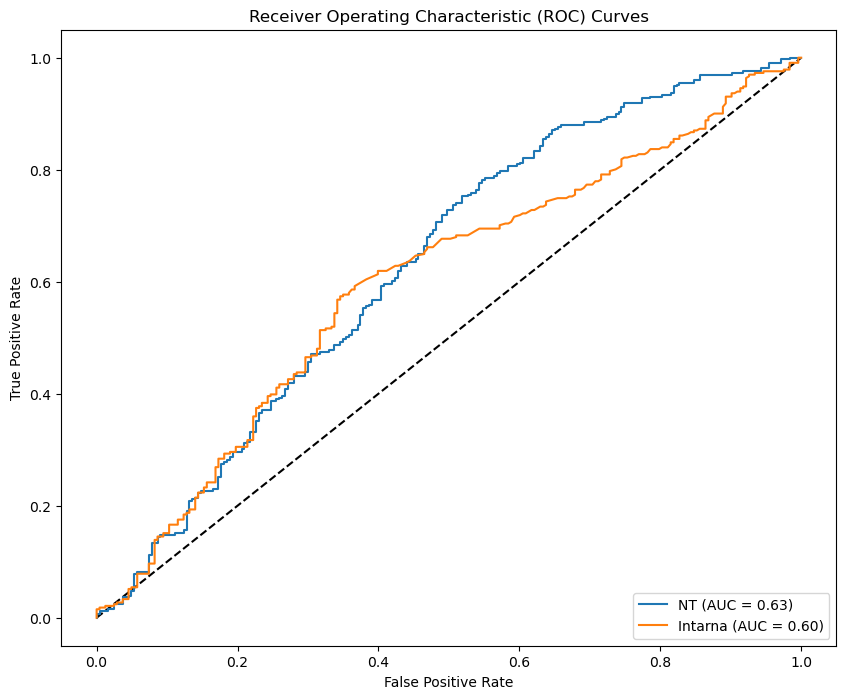

In [50]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.01)

perc of the total data:  0.3 %


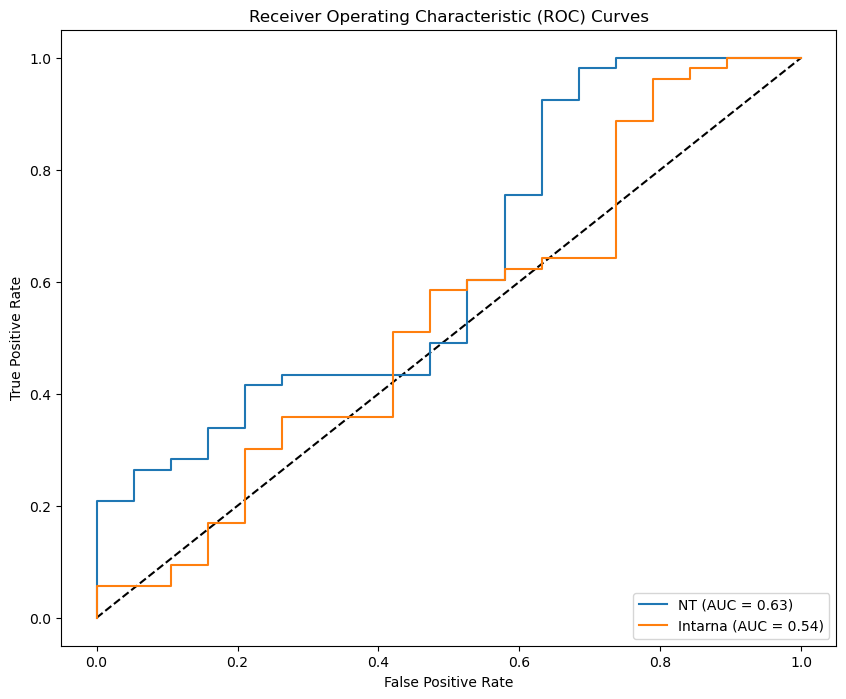

In [51]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

Text(0.5, 0, 'Confidence & Perc%')

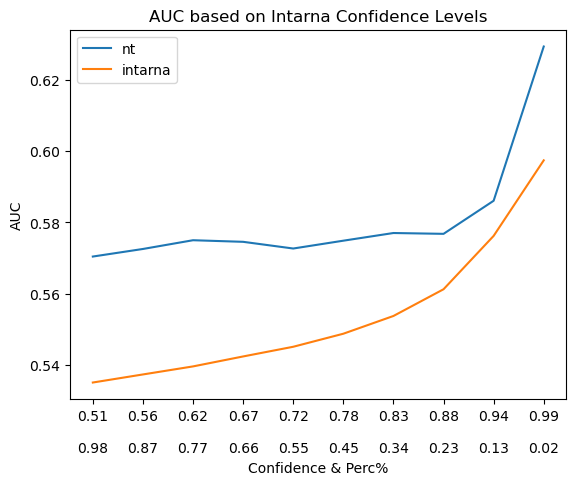

In [52]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

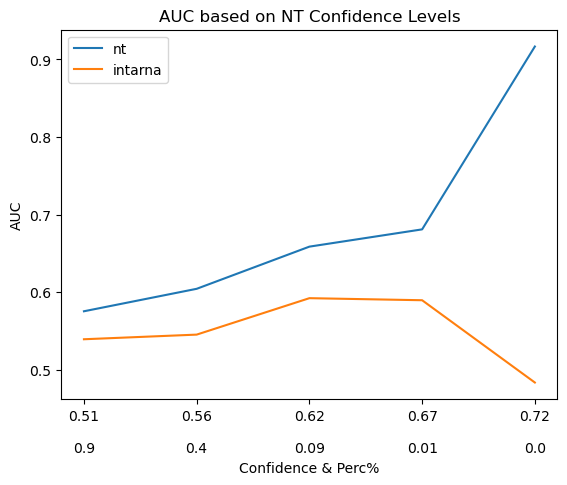

In [53]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

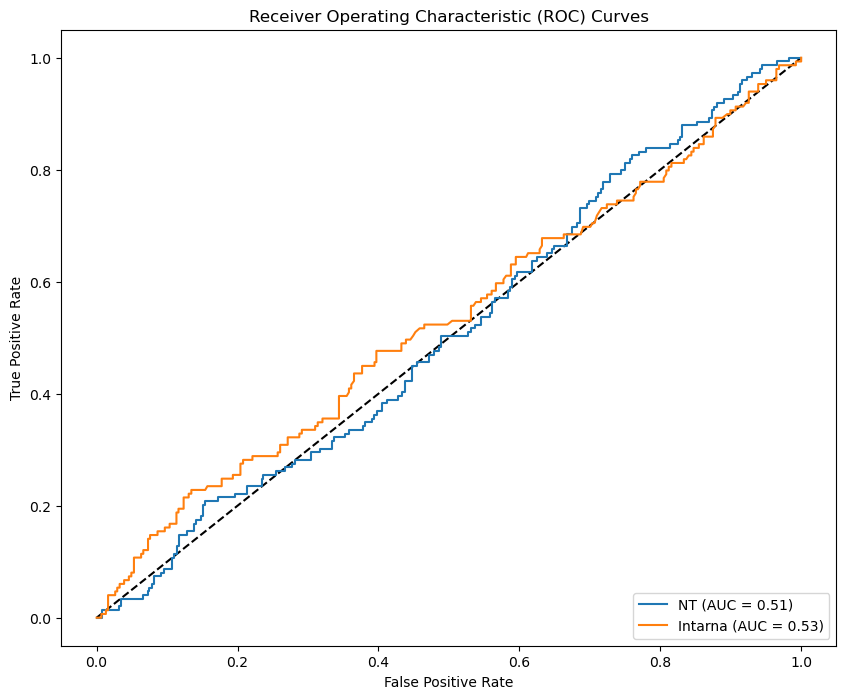

In [54]:
n_iters = 100

lists = []

for i in range(n_iters):

    not_in_train_epsn = easypos_smartneg[~(easypos_smartneg.gene1_original.isin(df_train_genes) | easypos_smartneg.gene2_original.isin(df_train_genes))]

    negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
    poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

    not_in_train_epsn = pd.concat([negs.sample(len(poss)), poss], axis = 0)
    lists.append(not_in_train_epsn)

not_in_train_epsn = pd.concat(lists, axis = 0)

plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn.ground_truth)

In [55]:
treshold = 0.7
subset_where_disagree = easypos_smartneg[
                (easypos_smartneg.probability >= treshold)|
                (easypos_smartneg.probability <= (1-treshold))
            ]

In [56]:
subset_where_disagree.ground_truth.value_counts()

1    53
0    19
Name: ground_truth, dtype: int64

### Estimate bias due to genes degree. PT1

In [147]:
# diff = df_nt[['couples_id', 'diff1', 'diff2']].dropna()
# new_cols = diff.couples_id.str.extractall('(.*)_(.*)').reset_index()
# diff['gene1'] = new_cols[0]
# diff['gene2'] = new_cols[1]
# diff = pd.concat([
#     diff[['gene1', 'diff1']].rename({'gene1':'gene', 'diff1':'diff'}, axis = 1),
#     diff[['gene2', 'diff2']].rename({'gene2':'gene', 'diff2':'diff'}, axis = 1)
# ], axis = 0)
# gb = diff.groupby('gene').std()
# assert gb[gb['diff'] >= 0.001].shape[0] == 0
# diff = diff.drop_duplicates('gene')
# diff['abs_diff'] = abs(diff['diff'])

In [148]:
# subset_where_disagree = subset_where_disagree.merge(diff, how = 'left', left_on = 'gene1_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff1'}, axis = 1)
# subset_where_disagree = subset_where_disagree.merge(diff, how = 'left', left_on = 'gene2_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff2'}, axis = 1)
# subset_where_disagree['diff1'] = subset_where_disagree['diff1'].fillna(0)
# subset_where_disagree['diff2'] = subset_where_disagree['diff2'].fillna(0)
# subset_where_disagree['sum_diff'] = subset_where_disagree['diff1'] + subset_where_disagree['diff2']

In [149]:
# quantile_level = 0.95

# problematic_genes = set(diff[diff.abs_diff> diff.abs_diff.quantile(quantile_level)].gene)

# print('the percentage of problematic genes is:', np.round(len(problematic_genes)/diff.shape[0] * 100, 2))

# perc = subset_where_disagree[
#     subset_where_disagree.gene1_original.isin(problematic_genes)|
#     subset_where_disagree.gene2_original.isin(problematic_genes)
# ].shape[0]/subset_where_disagree.shape[0]

# print('percentage of pairs belonging to problematic genes: ', np.round(perc*100, 2))

In [150]:
# perc = subset_where_disagree[
#     ((subset_where_disagree['sum_diff'] >= 0) & (subset_where_disagree['prediction'] == 0))|
#     ((subset_where_disagree['sum_diff'] <= 0) & (subset_where_disagree['prediction'] == 1))
# ].shape[0]/subset_where_disagree.shape[0]

# print('The percentage of pairs where the model predicts the sum of the degrees is: ', np.round(perc*100, 2))

### Estimate bias due to genes degree. PT2

In [151]:
# easypos_smartneg_sampled = easypos_smartneg_sampled.merge(diff, how = 'left', left_on = 'gene1_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff1'}, axis = 1)
# easypos_smartneg_sampled = easypos_smartneg_sampled.merge(diff, how = 'left', left_on = 'gene2_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff2'}, axis = 1)
# easypos_smartneg_sampled['diff1'] = easypos_smartneg_sampled['diff1'].fillna(0)
# easypos_smartneg_sampled['diff2'] = easypos_smartneg_sampled['diff2'].fillna(0)
# easypos_smartneg_sampled['sum_diff'] = easypos_smartneg_sampled['diff1'] + easypos_smartneg_sampled['diff2']
# easypos_smartneg_sampled['abs_sum_diff'] = abs(easypos_smartneg_sampled['sum_diff'])

In [152]:
# acc = []
# degree = []

# n_values = 250
# linspace = np.linspace(0.01, easypos_smartneg_sampled.abs_sum_diff.max() + 1, n_values)
# for i in range(n_values):
#     subset = easypos_smartneg_sampled[easypos_smartneg_sampled.abs_sum_diff<linspace[i]]
#     #subset = subset[subset.probability>0.7]
#     accuracy = subset[subset.ground_truth == subset.prediction].shape[0]/subset.shape[0]
#     acc.append(accuracy)
#     degree.append(linspace[i])

In [153]:
# plt.plot(degree, acc)
# plt.title('Accuracy based on degree unbalancing Levels')
         
# plt.ylabel('Accuracy')
# plt.xlabel('Unbalancing level')